In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

sns.set_style("whitegrid")

In [11]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

In [12]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print(f"Baseline accuracy on test data: {clf.score(X_test, y_test):.2}")

Baseline accuracy on test data: 0.97


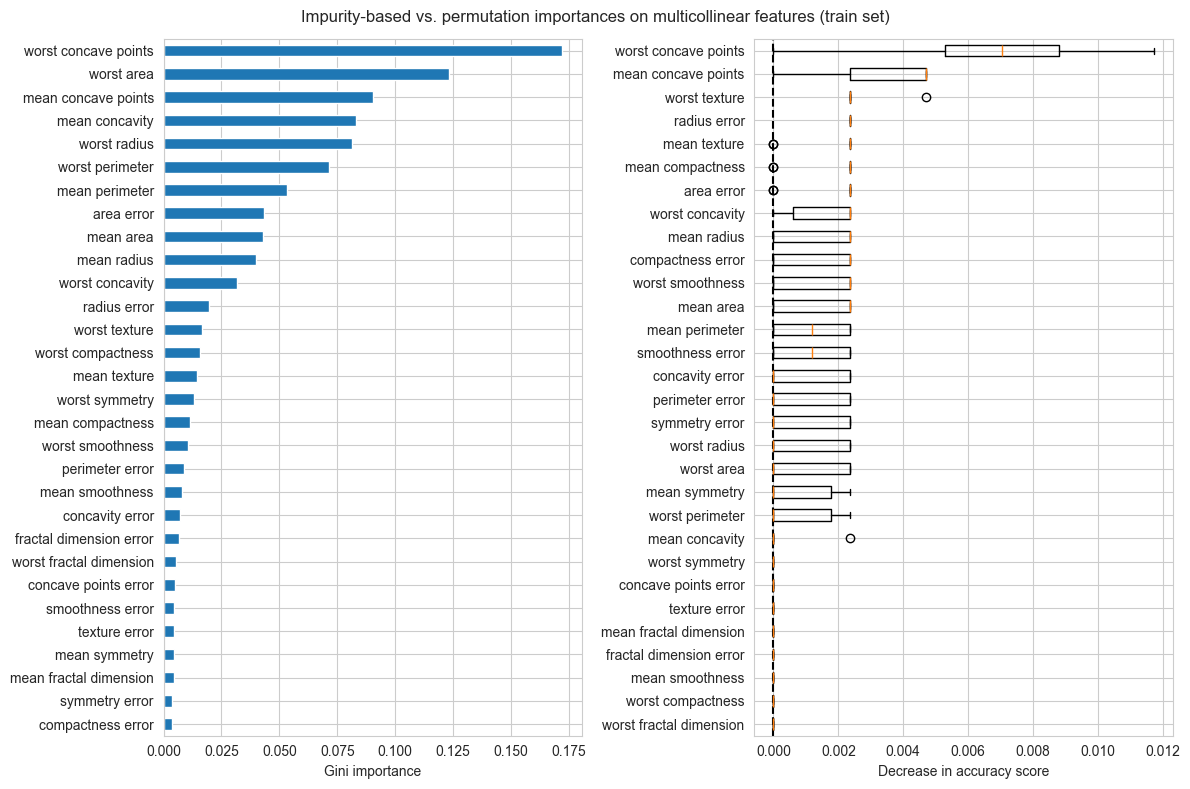

In [13]:
mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
mdi_importances.sort_values().plot.barh(ax=ax1)
ax1.set_xlabel("Gini importance")
plot_permutation_importance(clf, X_train, y_train, ax2)
ax2.set_xlabel("Decrease in accuracy score")
fig.suptitle(
    "Impurity-based vs. permutation importances on multicollinear features (train set)"
)
_ = fig.tight_layout()

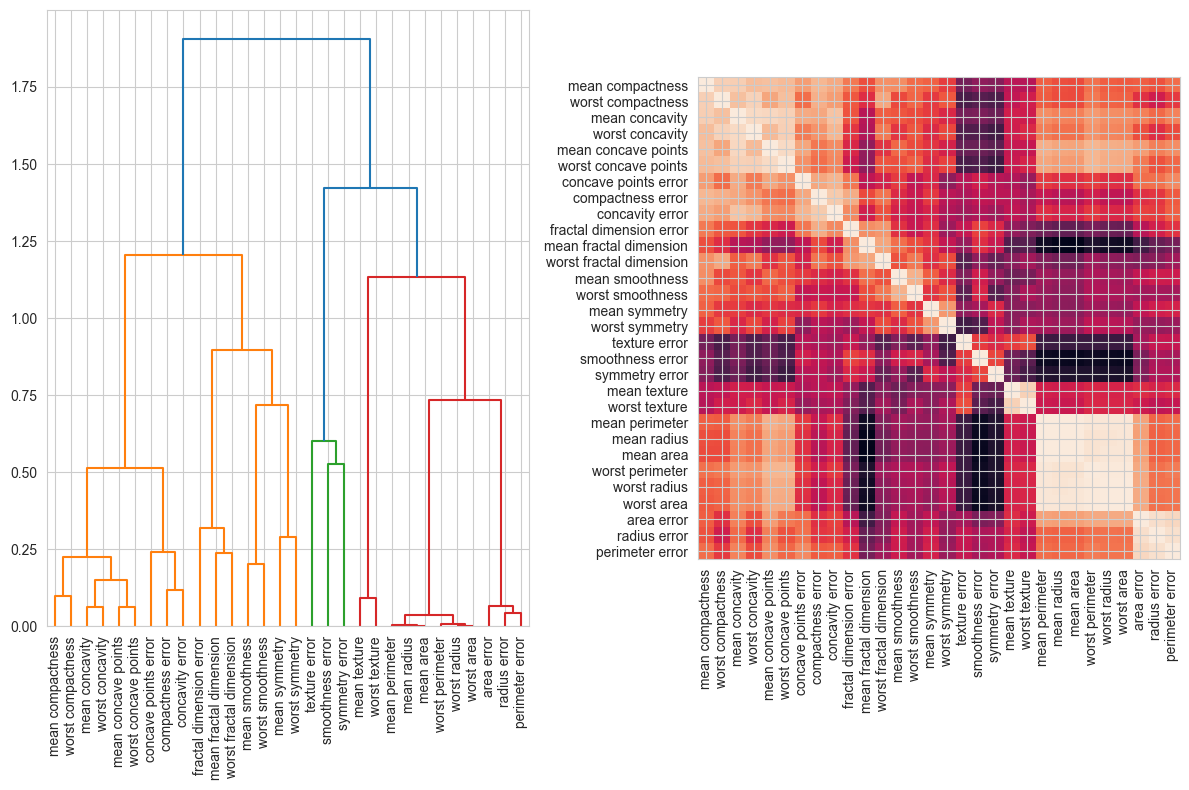

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)
distance_matrix = 1 - np.abs(corr)
distance_condensed = squareform(distance_matrix)
dist_linkage = hierarchy.linkage(distance_condensed, method="ward")
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

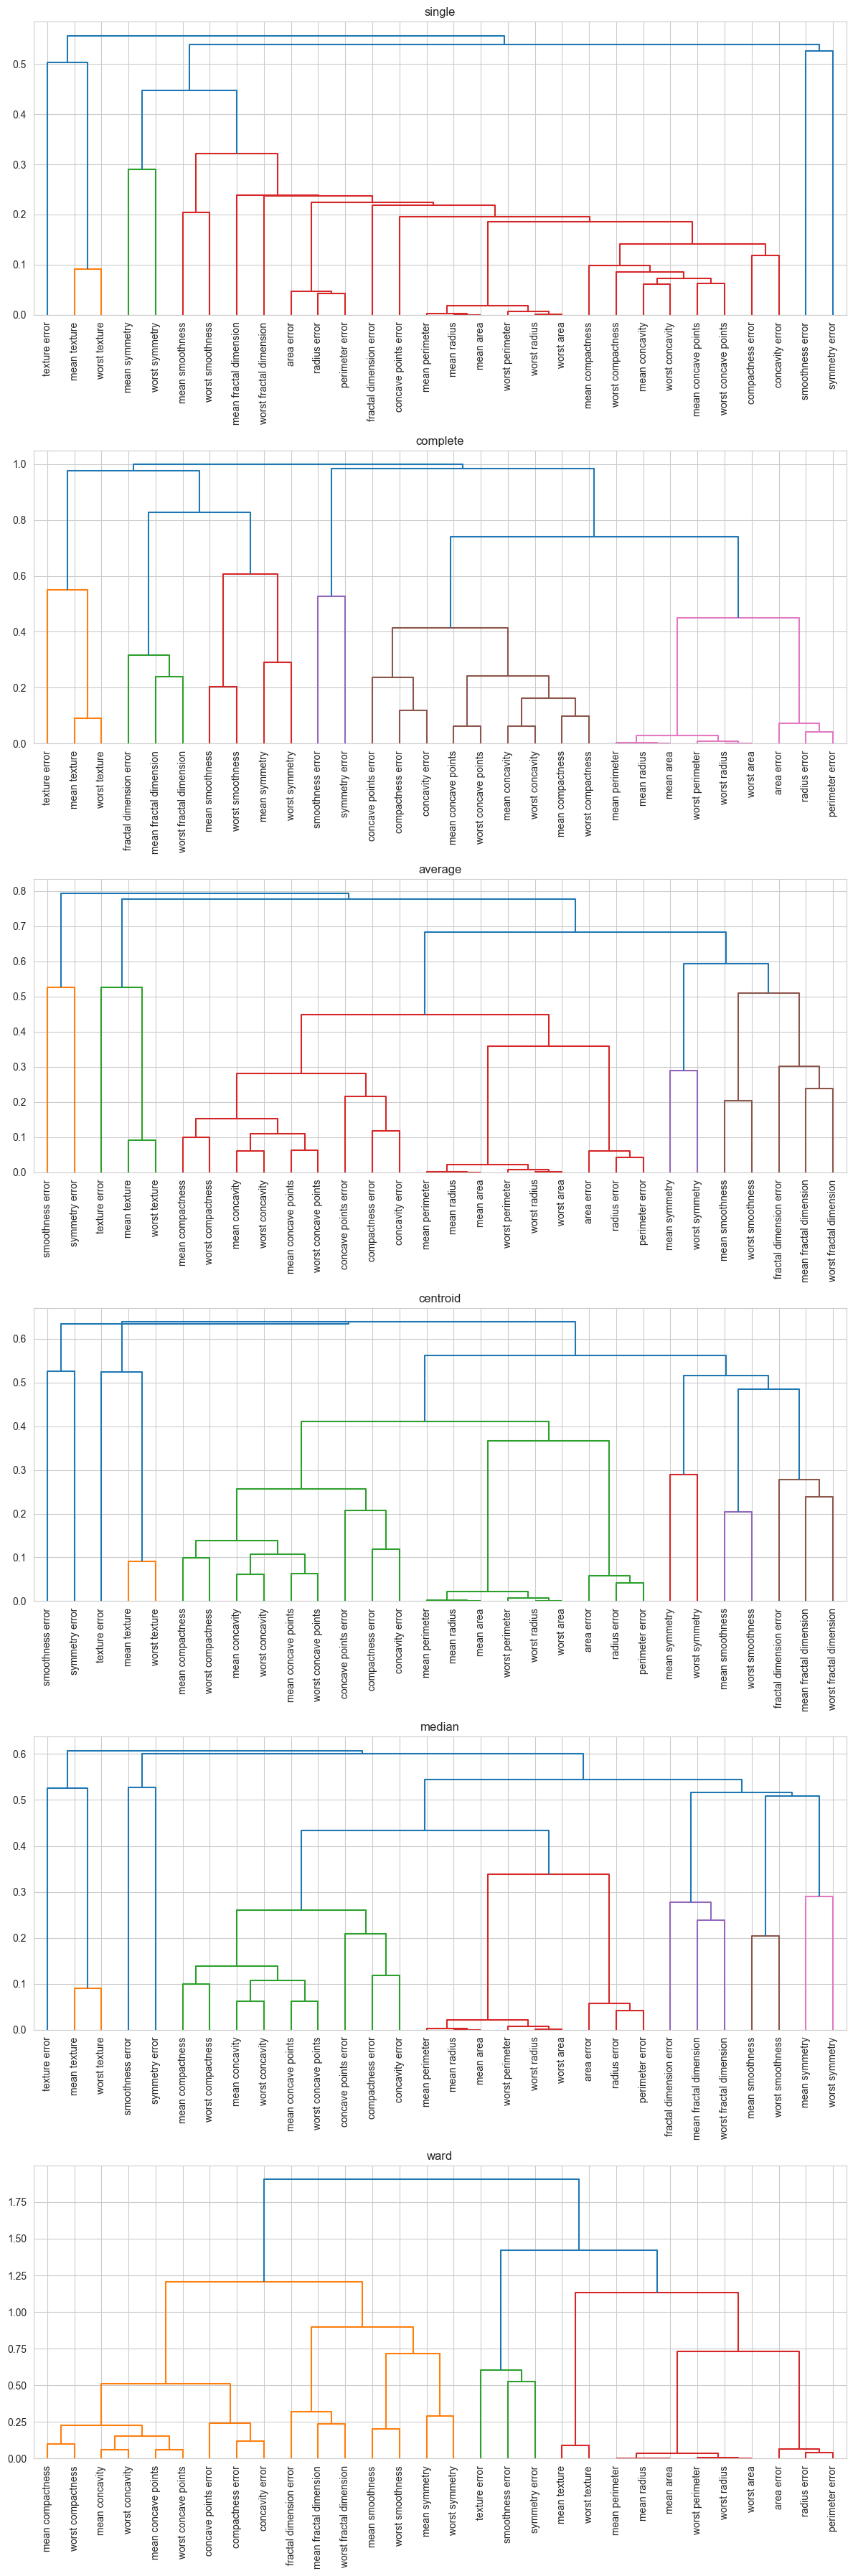

In [49]:
method_list = ["single", "complete", "average", "centroid", "median", "ward"]
fig, ax = plt.subplots(
    ncols=1, nrows=len(method_list), figsize=(12, int(len(method_list) * 6))
)
for i, method in enumerate(method_list):
    corr = spearmanr(X).correlation
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)
    distance_matrix = 1 - np.abs(corr)
    distance_condensed = squareform(distance_matrix)
    dist_linkage = hierarchy.linkage(distance_condensed, method=method)
    hierarchy.dendrogram(
        dist_linkage, labels=X.columns.to_list(), ax=ax[i], leaf_rotation=90
    )
    ax[i].set_title(method)
plt.tight_layout()
plt.show()